In [33]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def loadFiles( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(outputtype=pd.DataFrame, flatten=flatenndf)
    return data

### PREPARE DATA ####
MATCHES = "run8413_match_track_light.txt"
LIGHTINFO = "run8413_light_new_timing_files.txt"
FILENAMES = [ line.strip() for line in open(LIGHTINFO, "r") ]
PECUT = 300

print(len(FILENAMES))

## Get the data and combine the two cryostats
dfw = pd.concat( [loadFiles(FILENAME, "simpleLightAna/opflashCryoW_flashtree") for FILENAME in FILENAMES[100:200] ] )
dfw["cryo"] = 1
dfe = pd.concat( [loadFiles(FILENAME, "simpleLightAna/opflashCryoE_flashtree") for FILENAME in FILENAMES[100:200] ] )
dfe["cryo"] = 0
df = pd.concat([dfe, dfw])

## Now match with the selected tracks
dfmatches = pd.read_csv(MATCHES)
#_sel_dir_x = (dfmatches.trackDirX > -0.15) & (dfmatches.trackDirX < 0.15 )
#_seldir= _sel_dir_x
#dfmatches = dfmatches[_seldir]
dfmatches.rename(columns={'flashID':"flash_id"}, inplace=True)
dfmatches.set_index(["run", "event", "cryo", "flash_id"], inplace=True)
df = (df.join( dfmatches, on=["run", "event", "cryo", "flash_id"], how='inner'))
print("Consider {} tracks".format( len(df) ) )

## Explode the dataframe 
df["channel_id"] = df.y_pmt.apply( lambda x : np.arange(len(x)) )
df = df.explode(["time_pmt", "y_pmt", "pe_pmt", "z_pmt", "channel_id"])

cosmics = pd.read_csv( "cosmics_timing_run8413.txt" ).set_index("channel_id")
df = df.join( cosmics["means"], on="channel_id" )
df["time_pmt"] = df["time_pmt"]-df["means"]
      
## Remove the entries that do not have enough PE
_sel = df.pe_pmt > PECUT
df = df[_sel]

330
Consider 2072 tracks


In [34]:
from scipy import stats

meandf = df[["run", "event", "cryo", "flash_id", "time_pmt", "pe_pmt", "y_pmt"]].groupby(["run", "event", "cryo", "flash_id", "y_pmt"]).apply( 
    lambda x : pd.Series( {
        "weight_mean_time" : np.average(x.time_pmt, weights=x.pe_pmt), 
        "mean_time": np.mean(x.time_pmt),
        "error_mean_time": np.std(x.time_pmt) / np.sqrt(len(x.time_pmt))
    }) ).reset_index()

meandf = meandf.groupby(["run", "event", "cryo", "flash_id"]).agg(list)

def getdiff( y, t):
    # max y is on top : cosmics are going towards decreasing y 
    return t[np.argmin(y)] - t[np.argmax(y)]

def fittime( y, t ):
    try:
        res= stats.linregress(y, t)
        return res.intercept,  res.slope
    except:
        return 0,0

def residuals( tobs, y, a, b ):
    return tobs -  ( a + b*y )

meandf["diff_time"] = meandf.apply( lambda x : getdiff( x.y_pmt, x.mean_time ), axis=1 ) 
meandf[["intercept", "slope"]] = meandf.apply(lambda x : fittime(x.y_pmt, x.mean_time ), axis=1, result_type="expand" )

dfg = df.join( meandf[["intercept", "slope"]], on=["run", "event", "cryo", "flash_id"])
dfg["residuals"] = dfg.apply( lambda x : residuals(x.time_pmt, x.y_pmt, x.intercept, x.slope), axis=1 ) 

# Keep only the residuals on relevant PMT for that event
dfg = dfg[dfg.pe_pmt>PECUT]
print(len(dfg))

/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


51109


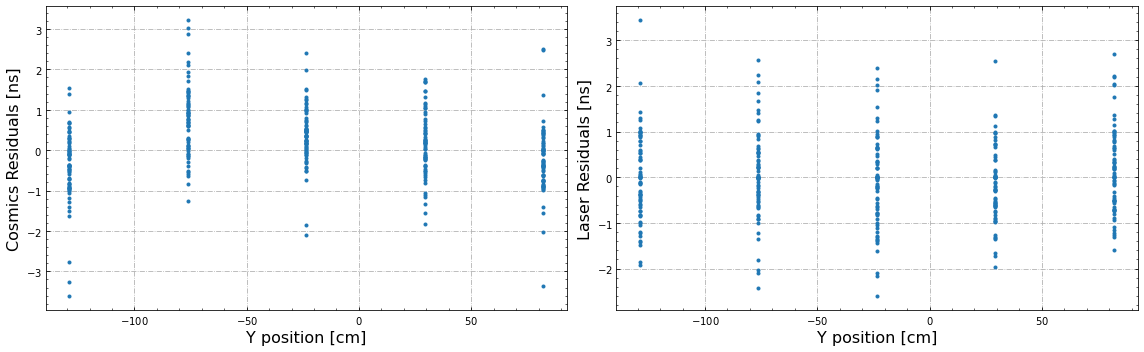

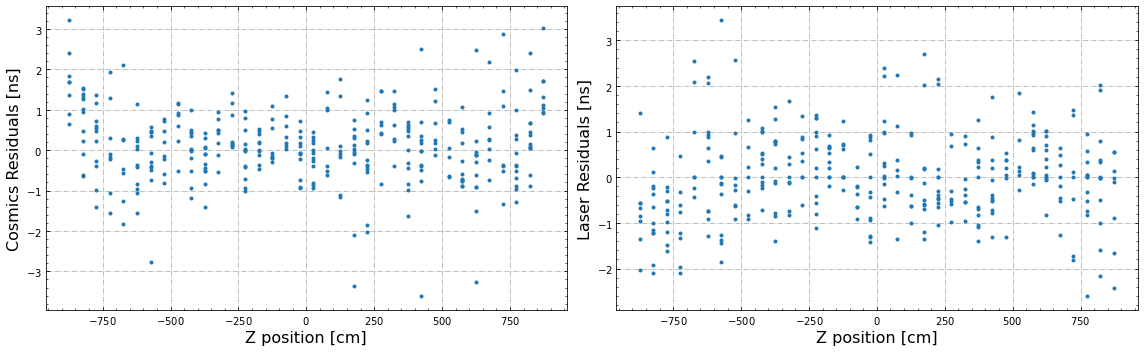

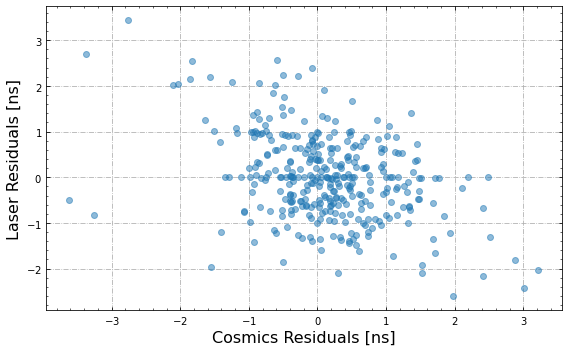

In [32]:
thisdfg = dfg.groupby(["channel_id"]).apply(
    lambda x : pd.Series( { 
            'entries' : len(x.residuals), 
            'means' : np.mean(x.residuals),
            'stds' : np.std(x.residuals),
            'emean' : np.std(x.residuals)/len(x.residuals),
            'y': np.mean(x.y_pmt),
            'z': np.mean(x.z_pmt)
        })).reset_index()


LASERCORR="/icarus/data/calibration/PMT/timing/dbfiles/laser_time_corrections_20220408.csv"
VOLTAGE="/icarus/data/calibration/PMT/timing/dbfiles/pmt_voltage_20220408.csv"
lasercorr = pd.read_csv(LASERCORR).set_index(["channel_id"])
voltage = pd.read_csv(VOLTAGE).set_index(["channel_id"])
thisdfg = thisdfg.join( lasercorr[["t_signal", "A", "B", "C"]], on="channel_id" ) 
thisdfg = thisdfg.join( voltage, on="channel_id" ) 
thisdfg["laser_res"] = thisdfg.apply( lambda x : x.t_signal-(x.A+x.B*np.power(x.voltage, x.C) ) , axis=1)

# Verify potential presence of biases 
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.y, y=thisdfg.means*1000, yerr=thisdfg.emean, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.y, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Y position [cm]", fontsize=16)
ax[0].set_xlabel("Y position [cm]", fontsize=16)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.z, y=thisdfg.means*1000, yerr=thisdfg.emean, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.z, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Z position [cm]", fontsize=16)
ax[0].set_xlabel("Z position [cm]", fontsize=16)
plt.tight_layout()
plt.show()

# plot them togheter
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.errorbar( x=thisdfg.means*1000, y=thisdfg.laser_res, yerr=0, marker='o', elinewidth=2.0, lw=0, alpha=0.5 )
ax.set_ylabel("Laser Residuals [ns]", fontsize=16)
ax.set_xlabel("Cosmics Residuals [ns]", fontsize=16)

plt.tight_layout()
plt.show()

thisdfg.to_csv( "cosmics_timing_run8413.txt", index=False )

In [27]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("matches_residuals_pe{}_testing.pdf".format(PECUT))

kargs = {'histtype':'step', 'linewidth':'2'}

for i, CH in enumerate(range(0, 360)) :
    
    fig = plt.figure(i, figsize=(6.8, 4.6))
    
    _selp=(dfg.channel_id==CH)
    
    nentries = len(dfg[_selp].residuals)
    means = np.mean(dfg[_selp].residuals)*1000
    stds = np.std(dfg[_selp].residuals)*1000
    
    label="\n".join(["ChannelID: {}".format(CH), 
                     "Entries: {}".format(nentries), 
                     "Mean: {:.2f} ns".format(means), 
                     "Std:  {:.2f} ms".format(stds) 
                    ])
    
    plt.hist( dfg[_selp].residuals*1000, bins=30, range=(-10, 20), label=label, **kargs) 
    plt.ylabel("Arb. units", fontsize=16)
    plt.xlabel("Time [ns]", fontsize=16)
    
    plt.legend(fontsize=14)
    pdf.savefig(fig)
    plt.close(fig)
    
pdf.close()

7270 1207


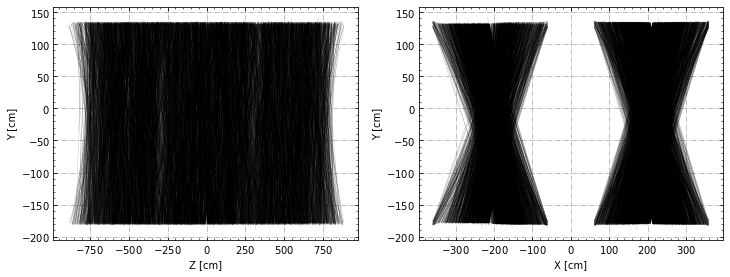

In [63]:
fig, ax = plt.subplots(1,2, figsize=(12, 4.3))

ax[0].plot( [dfmatches.trackEndZ, dfmatches.trackStartZ], [dfmatches.trackEndY, dfmatches.trackStartY], color='black', lw=0.1 )
ax[1].plot( [dfmatches.trackEndX, dfmatches.trackStartX], [dfmatches.trackEndY, dfmatches.trackStartY], color='black', lw=0.1 )

# consider steeper angle
_sel_dir_z=(dfmatches.trackDirZ > -0.3) & (dfmatches.trackDirZ < 0.3 ) 
_sel_dir_x = (dfmatches.trackDirX > -0.1) & (dfmatches.trackDirX < 0.1 )
_seldir= _sel_dir_x
#ax[0].plot( [dfmatches[_seldir].trackEndZ, dfmatches[_seldir].trackStartZ], [dfmatches[_seldir].trackEndY, dfmatches[_seldir].trackStartY], color='red', lw=0.1 )
#ax[1].plot( [dfmatches[_seldir].trackEndX, dfmatches[_seldir].trackStartX], [dfmatches[_seldir].trackEndY, dfmatches[_seldir].trackStartY], color='red', lw=0.1 )

print( len(dfmatches), len(dfmatches[_seldir]) )

ax[0].set_ylabel("Y [cm]" )  
ax[0].set_xlabel("Z [cm]" )  
ax[1].set_ylabel("Y [cm]" )  
ax[1].set_xlabel("X [cm]" )  

plt.show()

Index(['run', 'event', 'timestamp', 'flash_id', 'multiplicity',
       'multiplicity_right', 'multiplicity_left', 'sum_pe', 'sum_pe_right',
       'sum_pe_left', 'flash_time', 'pe_pmt', 'time_pmt', 'x_pmt', 'y_pmt',
       'z_pmt', 'flash_y', 'flash_width_y', 'flash_z', 'flash_width_z', 'cryo',
       'flashTime', 'trackTime', 'trackChargeZ', 'flashLightZ', 'flashLightY',
       'trackStartX', 'trackStartY', 'trackStartZ', 'trackEndX', 'trackEndY',
       'trackEndZ', 'trackDirX', 'trackDirY', 'trackDirZ', 'trackLenght',
       'Unnamed: 19', 'channel_id', 'means', 'intercept', 'slope', 'residuals',
       'walllength'],
      dtype='object')


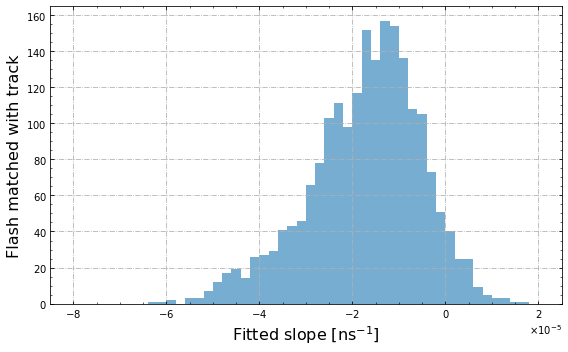

In [77]:
plt.figure(1, figsize=(8,5))
print(dfg.columns)
tt = dfg.groupby(["run", "event", "cryo", "flash_id"]).agg( {
    "slope":"mean", 
    "trackLenght":"mean", 
    "trackDirY":"mean", 
    "trackDirX":"mean", 
    "trackDirZ":"mean", 
    "flashLightZ":"mean",
    "pe_pmt":"sum"      } )


plt.hist( tt.slope, bins=50, range=(-8e-5, 2e-5), alpha=0.6 )
plt.ylabel("Flash matched with track", fontsize=16)
plt.xlabel("Fitted slope [ns$^{-1}$]", fontsize=16)
plt.tight_layout()
plt.show()


